In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import warnings
#from pandas.core.common import SettingWithCopyWarning
import plotly.express as px
from sklearn.preprocessing import QuantileTransformer
from umap import UMAP


#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
%matplotlib inline

df_pre = pd.read_excel('https://raw.githubusercontent.com/pfocordeiro/magnetite_app/main/MAG.xlsx')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [44]:
df_pre = df_pre[['Location', 'Model', 'Type', 'Reference', 'Lithology', 'Sample','Mg',  'Al', 'Si', 'Ti', 'V', 'Mn', 'Cr', 'Zn',  'Co', 'Ni', 'Ga']]

location = list(df_pre['Location'].value_counts().index)
clean = list(df_pre.drop(columns=['Location','Model', 'Type', 'Reference', 'Lithology', 'Sample']))

for i in df_pre[clean]:
    for n in location:
        df_pre[i].replace('B.D.L', np.nan, inplace=True)
        df_pre[i].replace('BDL', np.nan, inplace=True)
        df_pre[i].replace('B.D.L5', np.nan, inplace=True)
        df_pre[i].replace('bdl', np.nan, inplace=True)
        df_pre[i].replace('b.d', np.nan, inplace=True)
        df_pre[i].replace('b.d.', np.nan, inplace=True)
        df_pre[i].replace('bd', np.nan, inplace=True)
        df_pre[i].replace('na', np.nan, inplace=True)
        df_pre[i].replace(r'<.+', np.nan, regex=True, inplace=True)
        df_pre[i].replace('-.+', np.nan, inplace=True, regex=True)
        df_pre[i].replace('-', np.nan, inplace=True, regex = True)
        df_pre[i].replace(r'/\s/g', '', inplace=True, regex = True)
        df_pre[i] = pd.to_numeric(df_pre[i])
        df_pre[i] = df_pre[i].clip(lower=0)
        factor = df_pre[df_pre.Location == n][i].min()
        df_pre[i].replace([np.nan], factor, inplace=True)

df_pre.Type.fillna('Unassigned', inplace=True)

# Enforce minimum thresholds
thresholds = {
    'Al': 10,
    'Si': 2000,
    'Ti': 11,
    'V': 2,
    'Cr': 6,
    'Mn': 3,
    'Co': 1,
    'Ni': 2,
    'Zn': 6,
    'Ga': 1
}

for col, min_value in thresholds.items():
    df_pre.loc[df_pre[col] < min_value, col] = min_value

Streaming output truncated to the last 5000 lines.

  df_pre[i].replace('BDL', np.nan, inplace=True)
<ipython-input-44-3b6fa4e8b55e>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pre[i].replace('B.D.L5', np.nan, inplace=True)
<ipython-input-44-3b6fa4e8b55e>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

In [38]:
# Define lists of values to exclude
exclude_locations = ['Norilsk', 'Pulang', 'Disuga', 'Yuleken', 'Pha Lek', 'Akesayi', 'Lannitang', 'Panguna', 'Veliki Krivelj']
exclude_types = ['Titanomagnetite', 'Unaltered', 'Syenite', 'Granite', 'Andesite', 'Altered Andesite', 'Rhyodacite', 'Gushan', 'Dahongshan']

# Apply filtering
df = df_pre[
    (~df_pre['Location'].isin(exclude_locations)) &
    (~df_pre['Model'].isin(['Carbonatite'])) &
    (~df_pre['Type'].isin(exclude_types))
]

In [39]:
df.to_csv('MAG_INPUT.csv', index=False)
df_train = pd.read_csv('MAG_INPUT.csv')

In [40]:
from sklearn.preprocessing import PowerTransformer

# Drop specified columns
columns_to_drop = ['Location', 'Type', 'Reference', 'Sample', 'Lithology', 'Model']
df_dropped = df_train.drop(columns=columns_to_drop)

# Initialize and fit the PowerTransformer with method='box-cox'
# Note: Box-Cox requires all data to be positive
pt = PowerTransformer(method='box-cox')

# Apply the transformation
df_scaled = pt.fit_transform(df_dropped)

In [41]:
from umap import UMAP

# Initialize UMAP with specified parameters
reducer = UMAP(
    n_components=2,
    random_state=1,
    n_neighbors=600,
    a=15,
    b=12,
    min_dist=0.8,
    metric='manhattan'
)

# Fit and transform the scaled data
df_umap = reducer.fit_transform(df_scaled)

# Add UMAP components as new columns to df_train
df_train['umap_1'] = df_umap[:, 0]
df_train['umap_2'] = df_umap[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


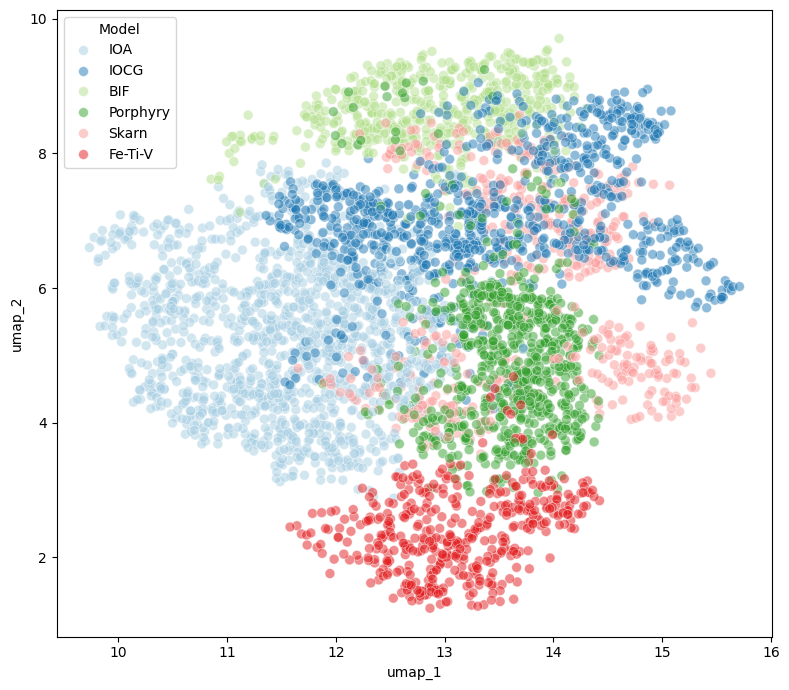

In [43]:
plt.figure(figsize=(8, 7))
sns.scatterplot(
    data=df_train,
    x='umap_1',
    y='umap_2',
    hue='Model',
    palette='Paired',
    s=50,
    alpha=0.5
)

plt.tight_layout()
# plt.savefig("3_globalstructure_model.jpg", dpi=300)
plt.show()

In [ ]:
fig_2d = px.scatter(
    df_train,
    x='umap_3',
    y='umap_4',
    color='Model',
    hover_data=['Model',"Location", "Type", 'Sample', 'Lithology', 'Reference'],
    color_discrete_sequence=px.colors.qualitative.Light24, width=600, height=500, template='simple_white')

fig_2d.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig_2d.show()
# fig_2d.write_html("1_interactive_global_model.html")

In [ ]:
import matplotlib.colors as colors

fig, ax = plt.subplots(4, 3, figsize=(11, 13))

a = ax[0,0].scatter(data=df_train, x='umap_3',y='umap_4',c=df_train.Mg,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(a,ax=ax[0,0])

ax[0,0].title.set_text('Mg')
ax[0,0].axis('off')

b = ax[0,1].scatter(data=df_train,x='umap_3',y='umap_4',c=df_train.Al,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(b,ax=ax[0,1])
ax[0,1].title.set_text('Al')
ax[0,1].axis('off')

c = ax[0,2].scatter(data=df_train,x='umap_3',y='umap_4',c=df_train.Si,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(c,ax=ax[0,2])
ax[0,2].title.set_text('Si')
ax[0,2].axis('off')

d = ax[1,0].scatter(data=df_train, x='umap_3',y='umap_4',c=df_train.Ti,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(d,ax=ax[1,0])
ax[1,0].title.set_text('Ti')
ax[1,0].axis('off')

e = ax[1,1].scatter(data=df_train,x='umap_3',y='umap_4',c=df_train.V,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(e,ax=ax[1,1])
ax[1,1].title.set_text('V')
ax[1,1].axis('off')

f = ax[1,2].scatter(data=df_train,x='umap_3',y='umap_4',c=df_train.Mn,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(f,ax=ax[1,2])
ax[1,2].title.set_text('Mn')
ax[1,2].axis('off')

g = ax[2,0].scatter(data=df_train, x='umap_3',y='umap_4',c=df_train.Cr,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(g,ax=ax[2,0])
ax[2,0].title.set_text('Cr')
ax[2,0].axis('off')

h = ax[2,1].scatter(data=df_train,x='umap_3',y='umap_4',c=df_train.Zn,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(h,ax=ax[2,1])
ax[2,1].title.set_text('Zn')
ax[2,1].axis('off')

i = ax[2,2].scatter(data=df_train,x='umap_3',y='umap_4',c=df_train.Co,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(i,ax=ax[2,2])
ax[2,2].title.set_text('Co')
ax[2,2].axis('off')

j = ax[3,0].scatter(data=df_train,x='umap_3',y='umap_4',c=df_train.Ni,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(j,ax=ax[3,0])
ax[3,0].title.set_text('Ni')
ax[3,0].axis('off')

k = ax[3,1].scatter(data=df_train,x='umap_3',y='umap_4',c=df_train.Ga,cmap='viridis', norm=colors.LogNorm())
fig.colorbar(k,ax=ax[3,1])
ax[3,1].title.set_text('Ga')
ax[3,1].axis('off')

l = sns.scatterplot(ax=ax[3,2],data=df_train, x='umap_3', y='umap_4', hue='Model',
               palette='Paired',
               s=50)
ax[3,2].title.set_text('Deposit Models')
ax[3,2].axis('off')
fig.colorbar(a,ax=ax[3,2])


plt.tight_layout()
# plt.savefig("3_globalstructure_maps.jpg", dpi=300)

In [ ]:
df_umap = UMAP(random_state=1, n_components=2, n_neighbors=24,
               a=1.2, b=0.74,
               min_dist=0,
               metric='manhattan').fit_transform(df_scaled)

df_train['umap_1'] = df_umap[:, 0]
df_train['umap_2'] = df_umap[:, 1]


In [ ]:
fig_2d = px.scatter(
    df_train,
    x='umap_1',
    y='umap_2',
    color='Model',
    hover_data=['Model',"Location", "Type", 'Sample', 'Lithology', 'Reference', 'Mg'],
    color_discrete_sequence=px.colors.qualitative.Light24, width=600, height=500, template='simple_white')

fig_2d.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig_2d.show()
# fig_2d.write_html("1_interactive_global_model.html")

In [ ]:
import hdbscan
import sklearn.cluster as cluster

predicted_labels = hdbscan.HDBSCAN(min_cluster_size=55,
                                   min_samples=55,
                                   ).fit_predict(df_umap)
df_train['hdbscan'] = list(predicted_labels)

In [ ]:
df_train.hdbscan.replace({0:17, 1:16, 2:18, 3:19, 4:4, 5:13, 6:0, 7:1, 8:14, 9:20, 10:21, 11:15, 12:12, 13:6, 14:7, 15:3, 16:5, 17:2, 18:11, 19:10, 20:9, 21:8}, inplace=True)


In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6.5, 16.5))


markers = {-1: "X", 0:'o', 1:'o', 2:'o', 3:'o', 4:'o', 5:'o', 6:'o', 7:'o', 8:'o', 9:'o', 10:'o', 11:'o', 12:'o', 13:'o', 14:'o', 15:'o', 16:'o', 17:'o', 18:'o', 19:'o', 20:'o', 21:'o'}

col_list = {'-1', '0', '1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'}

a = sns.scatterplot(ax=ax[0],
                data=df_train,
                x='umap_1',
                y='umap_2',
                hue='Model',
                s=50,
                palette='Paired'
                   )
ax[0].title.set_text('UMAP results by deposit model')
ax[0].xaxis.label.set_visible(False)
ax[0].yaxis.label.set_visible(False)

b = sns.scatterplot(ax=ax[1],
                data=df_train,
                x='umap_1',
                y='umap_2',
                hue='hdbscan',
#                 markers=markers,
#                 style = 'hdbscan',
                palette=palette,
                s=50)
ax[1].title.set_text('Umap results by Hdbscan clusterization')
ax[1].legend(loc=2, bbox_to_anchor=(1.05, 1))
ax[1].xaxis.label.set_visible(False)
ax[1].yaxis.label.set_visible(False)

c = sns.scatterplot(ax=ax[2],
                data=df_train[df_train.hdbscan != -1],
                x='umap_1',
                y='umap_2',
                hue='hdbscan',
                palette=palette,
                s=50)
ax[2].title.set_text('Umap results by Hdbscan Clusters (without unclassified datapoints)')
ax[2].legend(loc=2, bbox_to_anchor=(1.05, 1))
ax[2].xaxis.label.set_visible(False)
ax[2].yaxis.label.set_visible(False)

plt.tight_layout()
plt.savefig("3_hdbscan.jpg", dpi=300, bbox_inches='tight')

In [ ]:
df = df_train[df_train.hdbscan != -1]

fig_2d = px.scatter(
    df,
    x='umap_1',
    y='umap_2',
    color=df.hdbscan.astype('str'),
    hover_data=["Location", "Type", 'Sample', 'Lithology', 'Reference', 'hdbscan'],
    color_discrete_sequence=px.colors.qualitative.Light24, width=600, height=500, template='simple_white')

fig_2d.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig_2d.show()
fig_2d.write_html("1_interactive_hdbscan.html")

In [ ]:
df_ioa = df[df.Model == 'IOA']

fig_2d = px.scatter(
    df_ioa,
    x='umap_1',
    y='umap_2',
    color=df_ioa.Location,
    hover_data=["Location", "Type", 'Sample', 'Lithology', 'Reference', 'hdbscan'],
    color_discrete_sequence=px.colors.qualitative.Light24, width=600, height=500, template='simple_white')

fig_2d.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig_2d.show()
# fig_2d.write_html("1_interactive_ioa_deposit.html")



In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax = sns.scatterplot(ax=axes[1], data=df, y=(df.Al+df.Mn)/10000, x=(df.Ti+df.V)/10000,
                     hue=df['hdbscan'],
                   palette=palette)
ax.set(xscale='log', yscale='log',xlim=(0.001,20), ylim=(0.004,3))
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ax = sns.scatterplot(ax=axes[0], data=df, y=(df.Al+df.Mn)/10000, x=(df.Ti+df.V)/10000,
                     hue=df.Model,
                    palette='Paired')
ax.set(xscale='log', yscale='log', xlim=(0.001,20), ylim=(0.004,3))
plt.tight_layout()
# plt.savefig("1_nadoll_all.svg", dpi=300, bbox_inches='tight')
# plt.savefig("3_nadoll_all.jpg", dpi=300, bbox_inches='tight')

In [ ]:
fig_2d = px.scatter(
    df,
    x=df.Ti+df.V,
    y=df.Al+df.Mn,
    color=df.Model,
    hover_data=["Location", "Type", 'Sample', 'Lithology', 'Reference', 'hdbscan'],
    color_discrete_sequence=px.colors.qualitative.Light24, width=600, height=500, template='simple_white',log_x=True,log_y=True)

fig_2d.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig_2d.show()
# fig_2d.write_html("1_interactive_ioa_deposit.html")



###

In [ ]:
bulk = {'Al':15.4*10000,'Ga':17.5, 'Mn':0.1*10000, 'Mg':2.48*10000, 'Si':66.62*10000, 'Ti':0.64*10000, 'Zn':67, 'Co':17.3, 'V':97, 'Ni':47, 'Cr':92}

# bulk2 = {'Al':1,'Ga':1, 'Mn':1, 'Mg':1, 'Ti':1, 'Zn':1, 'Co':1, 'V':1, 'Ni':1, 'Cr':1}

# for i in list(bulk2.keys()):
#     df[i+'_'] = df[i]/ bulk2[i]

# df_melt_n = df.drop(columns=['Al_', 'Ga_', 'Mn_', 'Mg_', 'Ti_', 'Zn_', 'Co_', 'V_', 'Cr_',  'Ni_', 'Analysis_number', 'Fe', 'Temperature']).melt(id_vars=['Location', 'Model', 'Type','Reference', 'Lithology', 'Sample', 'hdbscan', 'umap_1', 'umap_2'],var_name="Element",  value_name="Concentration")

df=df[['Location', 'Model', 'Type', 'Reference', 'Lithology', 'Sample', 'Ti', 'Al', 'V', 'Mg', 'Mn', 'Si', 'Cr', 'Zn', 'Ni', 'Co', 'Ga', 'Zn', 'umap_1', 'umap_2', 'hdbscan']]

df_melt = df.melt(id_vars=['Location', 'Model', 'Type','Reference', 'Lithology', 'Sample', 'hdbscan', 'umap_1', 'umap_2'],var_name="Element",  value_name="Concentration")
#'Al', 'Ga', 'Mn', 'Mg', 'Ti', 'Zn', 'Co', 'V', 'Cr', 'Ni',

len(df)

In [ ]:
# f, axes = plt.subplots(4,3, figsize=(15, 20))

# df_melt = df_melt[df_melt.hdbscan != -1]

# #{'Si', 'Al','Mn', 'Mg', 'Ti', 'V', 'Nb', 'Sn', 'Ga', 'Ge', 'Zn', 'Cr', 'Co', 'Ni', 'Cu'}

# ax = sns.boxplot(ax=axes[0,0], data=df_melt[df_melt.Element == 'Mg'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()
# ax = sns.boxplot(ax=axes[0,1], data=df_melt[df_melt.Element == 'Al'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()
# ax = sns.boxplot(ax=axes[0,2], data=df_melt[df_melt.Element == 'Si'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()

# ax = sns.boxplot(ax=axes[1,0], data=df_melt[df_melt.Element == 'Ti'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()
# ax = sns.boxplot(ax=axes[1,1], data=df_melt[df_melt.Element == 'V'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()
# ax = sns.boxplot(ax=axes[1,2], data=df_melt[df_melt.Element == 'Mn'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()

# ax = sns.boxplot(ax=axes[2,0], data=df_melt[df_melt.Element == 'Cr'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()
# ax = sns.boxplot(ax=axes[2,1], data=df_melt[df_melt.Element == 'Zn'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()
# ax = sns.boxplot(ax=axes[2,2], data=df_melt[df_melt.Element == 'Co'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")
# ax.get_legend().remove()

# ax = sns.boxplot(ax=axes[3,0], data=df_melt[df_melt.Element == 'Ni'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")

# ax = sns.boxplot(ax=axes[3,1], data=df_melt[df_melt.Element == 'Ni'], x='Element',y='Concentration', hue='hdbscan', palette=palette)
# ax.set_yscale("log")


# plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=20, mode="expand", borderaxespad=0.)

# plt.tight_layout()

# plt.savefig('1_umap_boxplot.jpg', dpi=300)

In [ ]:
palette_lineplot = {-1:'#000000', '0:Fe-Ti-V Riviere Bell Complex':'#939799', '1:Fe-Ti-V Emeishan':'#222222', '2:Porphyry I':'#F3C300', '3:Porphyry II':'#875692', '4:IOCG-Various/IOA-Grangesberg':'#F38400', '5:Porphyry III/IOA-Los Colorados':'#A1CAF1', '6:Skarn-Yamansu':'#BE0032', '7:IOCG-Olympic Dam I':'#C2B280', '8:IOCG- Olympic Dam II':'#848482', '9:IOCG- Olympic Dam III':'#008856', '10:BIF-Lamego':'#E68FAC', '11:BIF-Various':'#0067A5', '12:El Romeral IV':'#F99379', '13:IOCG-Kiruna':'#604E97', '14:IOCG-Dahongshan':'#F6A600', '15:Cerro Negro Norte':'#B3446C', '16:IOA-Cerro Negro Norte IV/Fresia C':'#DCD300', '17: El Laco/San Vicente Alto (surface)':'#882D17', '18:IOA-Cristales Grandes S1/Laco Sur (deep)':'#8DB600', '19:IOA-Mariela/Fresia B':'#654522', '20: IOA-Cristales Grandes A/Rodados Negros':'#E25822', '21: Skarn-Various':'#003822'}

df_melt['hdbscan_label'] = df_melt['hdbscan']

df_melt.hdbscan_label.replace({0:'0:Fe-Ti-V Riviere Bell Complex', 1:'1:Fe-Ti-V Emeishan', 2:'2:Porphyry I', 3:'3:Porphyry II', 4:'4:IOCG-Various/IOA-Grangesberg', 5:'5:Porphyry III/IOA-Los Colorados', 6:'6:Skarn-Yamansu', 7:'7:IOCG-Olympic Dam I', 8:'8:IOCG- Olympic Dam II', 9:'9:IOCG- Olympic Dam III', 10:'10:BIF-Lamego', 11:'11:BIF-Various', 12:'12:El Romeral IV', 13:'13:IOCG-Kiruna', 14:'14:IOCG-Dahongshan', 15:'15:Cerro Negro Norte', 16:'16:IOA-Cerro Negro Norte IV/Fresia C', 17:'17: El Laco/San Vicente Alto (surface)', 18:'18:IOA-Cristales Grandes S1/Laco Sur (deep)', 19:'19:IOA-Mariela/Fresia B', 20:'20: IOA-Cristales Grandes A/Rodados Negros', 21:'21: Skarn-Various'}, inplace=True)

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(13,12))#, sharey=True, sharex=True)

plt.tight_layout()
sns.set_context("paper")
plt.subplots_adjust(#left=0.1,
#                     bottom=3,
#                     right=0.9,
#                     top=0.9,
                    wspace=0,
                    hspace=0.2)

g = sns.lineplot(ax=ax[0,0], x='Element', y='Concentration', data=df_melt, hue='Model', palette='Paired')
g.set_yscale('log')
g.set(ylim=(1, 100000))
ax[0,0].title.set_text('Magnetite composition average by deposit type')
ax[0,0].set(xlabel=None, ylabel='Concentration (ppm)')

df_melt_IOA_Skarn = df_melt[(df_melt.hdbscan == 18)|(df_melt.hdbscan == 19)| (df_melt.hdbscan == 20) | (df_melt.hdbscan ==21)]

h = sns.lineplot(ax=ax[0,1], x='Element', y='Concentration', data=df_melt_IOA_Skarn, hue='hdbscan_label', palette=palette_lineplot, hue_order=['18:IOA-Cristales Grandes S1/Laco Sur (deep)', '19:IOA-Mariela/Fresia B','20: IOA-Cristales Grandes A/Rodados Negros', '21: Skarn-Various'])
h.set_yscale('log')
h.set(ylim=(1, 100000))
ax[0,1].legend()
ax[0,1].title.set_text('Hydrothermal-dominated IOA and Skarns')
ax[0,1].set(xlabel=None, ylabel=None)
ax[0,1].set(yticklabels=[])

df_melt_IOA_altered2 = df_melt[(df_melt.hdbscan == 12)| (df_melt.hdbscan == 13) | (df_melt.hdbscan == 14) |(df_melt.hdbscan == 15)]

g = sns.lineplot(ax=ax[0,2],x='Element', y='Concentration', data=df_melt_IOA_altered2, hue='hdbscan_label', palette=palette_lineplot, hue_order=['12:El Romeral IV', '13:IOCG-Kiruna', '14:IOCG-Dahongshan', '15:Cerro Negro Norte'])
g.set_yscale('log')
g.set(ylim=(1, 100000))
ax[0,2].title.set_text('Transitional/Magmatic IOA and IOCGs')
ax[0,2].legend()
ax[0,2].set(xlabel=None , ylabel=None)
ax[0,2].set(yticklabels=[])

df_melt_IOA_altered3 = df_melt[(df_melt.hdbscan == 0)| (df_melt.hdbscan == 1)| (df_melt.hdbscan == 2)| (df_melt.hdbscan == 3)| (df_melt.hdbscan == 4) | (df_melt.hdbscan == 5)]

g = sns.lineplot(ax=ax[1,0], x='Element', y='Concentration', data=df_melt_IOA_altered3, hue='hdbscan_label', palette=palette_lineplot, hue_order=['0:Fe-Ti-V Riviere Bell Complex', '1:Fe-Ti-V Emeishan', '2:Porphyry I', '3:Porphyry II' , '4:IOCG-Various/IOA-Grangesberg', '5:Porphyry III/IOA-Los Colorados'])
g.set_yscale('log')
g.set(ylim=(1, 100000))
ax[1,0].title.set_text('Magmatic and magmatic-like hydrothermal deposits')
ax[1,0].legend()
ax[1,0].set(xlabel=None, ylabel='Concentration (ppm)')
ax[1,0].set(yticklabels=[])

df_melt_OD_BIF = df_melt[(df_melt.hdbscan == 6)| (df_melt.hdbscan == 7)| (df_melt.hdbscan == 8)| (df_melt.hdbscan == 9)| (df_melt.hdbscan == 10) | (df_melt.hdbscan == 11)]

g = sns.lineplot(ax=ax[1,1], x='Element', y='Concentration', data=df_melt_OD_BIF, hue='hdbscan_label', palette=palette_lineplot, hue_order=['6:Skarn-Yamansu', '7:IOCG-Olympic Dam I', '8:IOCG- Olympic Dam II', '9:IOCG- Olympic Dam III', '10:BIF-Lamego', '11:BIF-Various'])
g.set_yscale('log')
g.set(ylim=(1, 100000))
ax[1,1].title.set_text('Olympic Dam IOCG and various BIF and Skarn deposits')
ax[1,1].legend()
ax[1,1].set(xlabel=None, ylabel=None)
ax[1,1].set(yticklabels=[])

df_melt_IOA_anom = df_melt[(df_melt.hdbscan == 16)| (df_melt.hdbscan == 17)]

g = sns.lineplot(ax=ax[1,2],x='Element', y='Concentration', data=df_melt_IOA_anom, hue='hdbscan_label', palette=palette_lineplot, hue_order=['16:IOA-Cerro Negro Norte IV/Fresia C', '17: El Laco/San Vicente Alto (surface)'])
ax[1,2].title.set_text('Surface samples/late-stage IOA magnetite')
ax[1,2].legend()
g.set_yscale('log')
g.set(ylim=(1, 100000))
ax[1,2].set(xlabel=None, ylabel=None)
ax[1,2].set(yticklabels=[])

m1 = (df_melt.hdbscan == 5) & (df_melt.Model != 'Skarn') & (df_melt.Model != 'IOCG')
g = sns.lineplot(ax=ax[2,0], x='Element', y='Concentration', data=df_melt[m1], hue='Model',palette='Paired')
g.set_yscale('log')
ax[2,0].set(ylim=(1, 100000))
ax[2,0].title.set_text('Average magnetite composition within Cluster 5')
ax[2,0].set(xlabel=None, ylabel='Concentration (ppm)')
ax[2,0].legend()
#labels=['Porphyry - various', 'IOA - Los Colorados'])

m2 = (df_melt.hdbscan == 4) & (df_melt.Model != 'Skarn') & (df_melt.Model != 'Porphyry') & (df_melt.Location != 'Sossego') & (df_melt.Location != 'Candelaria') & (df_melt.Location != 'Olympic Dam')
g = sns.lineplot(ax=ax[2,1], x='Element', y='Concentration', data=df_melt[m2], hue='Location', palette='tab10')
g.set_yscale('log')
ax[2,1].set(ylim=(1, 100000))
ax[2,1].title.set_text('Average magnetite composition within Cluster 4')
ax[2,1].set(xlabel=None, ylabel=None)
ax[2,1].set(yticklabels=[])
ax[2,1].legend()
#labels=['IOCG - Ernest Henry', 'IOCG - Kwyjibo', 'IOA - Grangesberg'])

m3 = (df_melt.hdbscan == 8)
g = sns.lineplot(ax=ax[2,2], x='Element', y='Concentration', data=df_melt[m3], hue='Model', palette='Paired')
g.set_yscale('log')
ax[2,2].set(ylim=(1, 100000))
ax[2,2].title.set_text('Average magnetite composition within Cluster 8')
ax[2,2].legend()#title='Deposits')
ax[2,2].set(xlabel=None, ylabel=None)
ax[2,2].set(yticklabels=[])

# plt.savefig("3_spider_all_clusters_FeTiVorder.jpg", dpi=400, bbox_inches='tight')

# plt.savefig("1_spider_models.svg", dpi=300)
# plt.savefig("3_spider_models.jpg", dpi=300)

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(22, 7),sharey=True)

g = sns.scatterplot(ax=axes[0], data=df, x='V', y=df.Mg/df.Ti, hue=df.Model, palette='Paired')
g.set(xscale='log', yscale='log')
g.set_ylabel('Mg/Ti')
# g.set_xlabel('Ga*V')
g.set_title('BIF, IOA and Skarn I')

g = sns.scatterplot(ax=axes[1], data=df, x=df.Mg+df.Ni, y=df.Ti/df.V, hue=df.Model, palette='Paired')
g.set(xscale='log', yscale='log')
g.set_xlabel('Co+Ni')
g.set_title('IOA vs others')

g = sns.scatterplot(ax=axes[2], data=df, x='Ga', y=df.Mg/df.Ti, hue=df.Model, palette='Paired')
g.set(xscale='log', yscale='log')
g.set_title('Porphyry vs Fe-Ti-V vs IOCG')
# g.set_xlabel('Mn*Al')
plt.tight_layout()

# plt.savefig("3_binaryclassification.jpg", dpi=300, bbox_inches='tight')

In [ ]:
# fig, axes = plt.subplots(1,2, figsize=(22, 7))

# g = sns.scatterplot(ax=axes[0], data=df, x=df.Ga*df.V, y=df.Mg/df.Ti, hue=df.Model, palette='Paired')
# g.set(xscale='log', yscale='log', ylim=(0.001, 2000))
# g.set_ylabel('Mg/Ti')
# g.set_xlabel('Ga*V')
# g.set_title('BIF, IOA, Skarn, IOCG')

# g = sns.scatterplot(ax=axes[1], data=df, x=df.Zn/df.Co, y=df.Mn*df.Al, hue=df.Model, palette='Paired')
# g.set(xscale='log', yscale='log', ylim=(200, 100000000))
# g.set_ylabel('Mn*Al')
# g.set_xlabel('Zn/Co')
# g.set_title('IOA vs others')


# plt.savefig("3_binaryclassification2.jpg", dpi=300, bbox_inches='tight')

In [ ]:
# fig, axes = plt.subplots(1,3, figsize=(22, 7))

# g = sns.scatterplot(ax=axes[0], data=df, x=df.Mn, y=df.Mg, hue=df.hdbscan, palette='Paired')


# g = sns.scatterplot(ax=axes[1], data=df, x=df.Co, y=df.Mg, hue=df.hdbscan, palette='Paired')

# g = sns.scatterplot(ax=axes[2], data=df, x=df.Zn, y=df.Mg, hue=df.hdbscan, palette='Paired')
# g.set(ylim=(0,10000), xlim=(0,10000))

In [ ]:
len(df_scaled)

In [ ]:
df_umap = UMAP(random_state=1, n_components=2, n_neighbors=100,
               min_dist=0.8,
               a=12, b=11,
               metric='manhattan').fit_transform(df_scaled)

df_pre['umap_3'] = df_umap[:, 0]
df_pre['umap_4'] = df_umap[:, 1]

plt.figure(figsize=(8,7), tight_layout=True)

sns.scatterplot(data=df_pre, x='umap_3', y='umap_4', hue='Model',
               palette='Paired',
               s=50, alpha=0.5)

plt.tight_layout()
# plt.savefig("3_globalstructure_model.jpg", dpi=300)


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

markers = {-1: "X", 0:'o', 1:'o', 2:'o', 3:'o', 4:'o', 5:'o', 6:'o', 7:'o', 8:'o', 9:'o', 10:'o', 11:'o', 12:'o', 13:'o', 14:'o', 15:'o', 16:'o', 17:'o', 18:'o', 19:'o', 20:'o', 21:'o'}

col_list = {'-1', '0', '1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'}

i = sns.scatterplot(ax=ax[0,0],
                data=df_pre,
                x='umap_3',
                y='umap_4',
                hue='Model',
                s=50,
                palette='Paired', alpha=0.5)
ax[0,0].title.set_text('UMAP - Global structure by deposit model')
# ax[0].axis('off')

a = sns.scatterplot(ax=ax[0,1],
                data=df_pre,
                x='umap_1',
                y='umap_2',
                hue='Model',
                s=50,
                palette='Paired', alpha=0.5)
ax[0,1].title.set_text('UMAP - Local structure by deposit model')
# ax[0].axis('off')

b = sns.scatterplot(ax=ax[1,0],
                data=df_pre,
                x='umap_1',
                y='umap_2',
                hue='hdbscan',
                markers=markers,
                style = 'hdbscan',
                palette=palette,
                s=50)
ax[1,0].title.set_text('Umap results by Hdbscan clusterization')
# ax[1,0].axis('off')
# ax[1,0].legend(loc=2, bbox_to_anchor=(1.05, 1))
ax[1,0].get_legend().remove()

c = sns.scatterplot(ax=ax[1,1],
                data=df_pre[df_pre.hdbscan != -1],
                x='umap_1',
                y='umap_2',
                hue='hdbscan',
                palette=palette,
                s=50)
ax[1,1].title.set_text('Umap results by Hdbscan Clusters (without unclassified datapoints)')
# ax[1,1].axis('off')
# ax[2].get_legend().remove()
ax[1,1].legend(loc=2, bbox_to_anchor=(1.05, 1))

# plt.tight_layout()
# plt.savefig("3_hdbscan.jpg", dpi=300, bbox_inches='tight')
